# OLS Múltiple con Statsmodels

Este notebook implementa un modelo OLS (Ordinary Least Squares) múltiple usando statsmodels.

## Características:
- Múltiples variables explicativas (numéricas y categóricas)
- Preprocesamiento con OneHotEncoder para variables categóricas
- Estadísticas detalladas (p-valores, intervalos de confianza)
- Tests de diagnóstico (heterocedasticidad, autocorrelación)
- Métricas de información (AIC, BIC)
- Análisis de influencia y outliers
- Tests de significancia estadística
- Mejor para análisis estadístico formal


In [1]:
# Imports y configuración
import numpy as np
import pandas as pd
from pathlib import Path
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import OLSInfluence
from scipy import stats
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Configuración de la ruta y columnas
CSV_PATH = Path(r'C:\Users\INMORTAL\OneDrive\Documentos\python\notebooks\modelos\Data\Global_Cybersecurity_Threats_2015-2024.csv')

# Para regresión múltiple: varias columnas X (numéricas y/o categóricas)
COLS_X_MULTIPLE = [
    'Year',
    'Country',
    'Attack Type',
    'Target Industry',
    'Number of Affected Users',
    'Attack Source',
    'Security Vulnerability Type',
    'Defense Mechanism Used'
]

COL_Y = 'Financial Loss (in Million $)'      # variable objetivo

# Carga de datos
if not CSV_PATH.exists():
    raise FileNotFoundError(f'No existe el CSV en: {CSV_PATH.resolve()}')

df = pd.read_csv(CSV_PATH)
print('Shape:', df.shape)
print('Columnas:', list(df.columns))
df.head()


Shape: (3000, 10)
Columnas: ['Country', 'Year', 'Attack Type', 'Target Industry', 'Financial Loss (in Million $)', 'Number of Affected Users', 'Attack Source', 'Security Vulnerability Type', 'Defense Mechanism Used', 'Incident Resolution Time (in Hours)']


,Country,Year,Attack Type,Target Industry,Financial Loss (in Million $),Number of Affected Users,Attack Source,Security Vulnerability Type,Defense Mechanism Used,Incident Resolution Time (in Hours)
0,China,2019,Phishing,Education,80.53,773169,Hacker Group,Unpatched Software,VPN,63
1,China,2019,Ransomware,Retail,62.19,295961,Hacker Group,Unpatched Software,Firewall,71
2,India,2017,Man-in-the-Middle,IT,38.65,605895,Hacker Group,Weak Passwords,VPN,20
3,UK,2024,Ransomware,Telecommunications,41.44,659320,Nation-state,Social Engineering,AI-based Detection,7
4,Germany,2018,Man-in-the-Middle,IT,74.41,810682,Insider,Social Engineering,VPN,68


In [2]:
# Preparación de datos para OLS múltiple
print("=== OLS MÚLTIPLE CON STATSMODELS ===")

# Verificar que las columnas existen
for col in COLS_X_MULTIPLE:
    if col not in df.columns:
        raise ValueError(f'La columna {col} no existe en el DataFrame.')
if COL_Y not in df.columns:
    raise ValueError('Revisa COL_Y. No existe en el DataFrame.')

X_mult = df[COLS_X_MULTIPLE].copy()
y_mult = df[COL_Y].copy()

# Separar por tipo
dtypes = X_mult.dtypes
num_features = [c for c in X_mult.columns if dtypes[c].kind in ['i', 'u', 'f']]
cat_features = [c for c in X_mult.columns if c not in num_features]

print(f"Variables numéricas: {num_features}")
print(f"Variables categóricas: {cat_features}")

# Preprocesamiento: OneHot para categóricas, passthrough para numéricas
preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
        ('num', 'passthrough', num_features)
    ]
)

# Aplicar preprocesamiento
X_mult_processed = preprocess.fit_transform(X_mult)
feature_names_processed = []

# Obtener nombres de características después del preprocesamiento
if cat_features:
    ohe = preprocess.named_transformers_['cat']
    ohe_names = list(ohe.get_feature_names_out(cat_features))
    feature_names_processed.extend(ohe_names)
feature_names_processed.extend(num_features)

# Convertir matriz dispersa a densa si es necesario
if hasattr(X_mult_processed, 'toarray'):
    X_mult_processed = X_mult_processed.toarray()

print(f"Número de características después del preprocesamiento: {X_mult_processed.shape[1]}")
print(f"Nombres de características: {feature_names_processed[:10]}...")  # Mostrar solo las primeras 10


=== OLS MÚLTIPLE CON STATSMODELS ===
Variables numéricas: ['Year', 'Number of Affected Users']
Variables categóricas: ['Country', 'Attack Type', 'Target Industry', 'Attack Source', 'Security Vulnerability Type', 'Defense Mechanism Used']
Número de características después del preprocesamiento: 38
Nombres de características: ['Country_Australia', 'Country_Brazil', 'Country_China', 'Country_France', 'Country_Germany', 'Country_India', 'Country_Japan', 'Country_Russia', 'Country_UK', 'Country_USA']...


In [3]:
# Crear y ajustar modelo OLS múltiple
# Agregar constante
X_mult_ols = sm.add_constant(X_mult_processed)
y_mult_ols = y_mult

# Crear y ajustar modelo OLS múltiple
model_ols_multiple = sm.OLS(y_mult_ols, X_mult_ols).fit()

# Mostrar resumen completo
print(model_ols_multiple.summary())


                                  OLS Regression Results                                 
Dep. Variable:     Financial Loss (in Million $)   R-squared:                       0.010
Model:                                       OLS   Adj. R-squared:                 -0.001
Method:                            Least Squares   F-statistic:                    0.9020
Date:                           Fri, 17 Oct 2025   Prob (F-statistic):              0.626
Time:                                   11:42:20   Log-Likelihood:                -14322.
No. Observations:                           3000   AIC:                         2.871e+04
Df Residuals:                               2967   BIC:                         2.891e+04
Df Model:                                     32                                         
Covariance Type:                       nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------

In [4]:
# Diagnósticos adicionales
print("\n=== DIAGNÓSTICOS OLS MÚLTIPLE ===")
print(f"R² ajustado: {model_ols_multiple.rsquared_adj:.4f}")
print(f"AIC: {model_ols_multiple.aic:.2f}")
print(f"BIC: {model_ols_multiple.bic:.2f}")
print(f"Log-Likelihood: {model_ols_multiple.llf:.2f}")

# Test de heterocedasticidad (Breusch-Pagan)
bp_stat, bp_pvalue, _, _ = het_breuschpagan(model_ols_multiple.resid, X_mult_ols)
print(f"Test Breusch-Pagan (heterocedasticidad): estadístico={bp_stat:.4f}, p-valor={bp_pvalue:.4f}")

# Test de Durbin-Watson (autocorrelación)
dw_stat = durbin_watson(model_ols_multiple.resid)
print(f"Test Durbin-Watson (autocorrelación): {dw_stat:.4f}")

# Test F para la significancia global del modelo
print(f"Test F (significancia global): F={model_ols_multiple.fvalue:.4f}, p-valor={model_ols_multiple.f_pvalue:.4f}")

# Interpretación de tests
print(f"\n=== INTERPRETACIÓN DE TESTS ===")
if bp_pvalue < 0.05:
    print("⚠️  Heterocedasticidad detectada (p < 0.05)")
else:
    print("✅ No hay evidencia de heterocedasticidad (p >= 0.05)")

if dw_stat < 1.5:
    print("⚠️  Posible autocorrelación positiva (DW < 1.5)")
elif dw_stat > 2.5:
    print("⚠️  Posible autocorrelación negativa (DW > 2.5)")
else:
    print("✅ No hay evidencia de autocorrelación (1.5 <= DW <= 2.5)")

if model_ols_multiple.f_pvalue < 0.05:
    print("✅ El modelo es estadísticamente significativo globalmente (p < 0.05)")
else:
    print("⚠️  El modelo no es estadísticamente significativo globalmente (p >= 0.05)")



=== DIAGNÓSTICOS OLS MÚLTIPLE ===
R² ajustado: -0.0010
AIC: 28710.05
BIC: 28908.26
Log-Likelihood: -14322.02
Test Breusch-Pagan (heterocedasticidad): estadístico=30.2344, p-valor=0.8111
Test Durbin-Watson (autocorrelación): 2.0341
Test F (significancia global): F=0.9020, p-valor=0.6257

=== INTERPRETACIÓN DE TESTS ===
✅ No hay evidencia de heterocedasticidad (p >= 0.05)
✅ No hay evidencia de autocorrelación (1.5 <= DW <= 2.5)
⚠️  El modelo no es estadísticamente significativo globalmente (p >= 0.05)



=== COEFICIENTES MÁS SIGNIFICATIVOS ===
Top 10 coeficientes más significativos:
                 Característica  Coeficiente   P-valor  T_estadístico
x6                Country_India   -12.521023  0.480391      -0.705764
x37                        Year     0.123187  0.504558       0.667417
x18   Target Industry_Education   -15.761171  0.532907      -0.623648
x3                Country_China   -11.039844  0.535091      -0.620325
x4               Country_France   -10.762660  0.543274      -0.607940
x20  Target Industry_Healthcare   -14.841959  0.556821      -0.587637
x25       Attack Source_Insider   -25.107972  0.569989      -0.568131
x12         Attack Type_Malware   -16.742887  0.570083      -0.567993
x7                Country_Japan    -9.985432  0.573995      -0.562240
x8               Country_Russia    -9.880865  0.577705      -0.556801


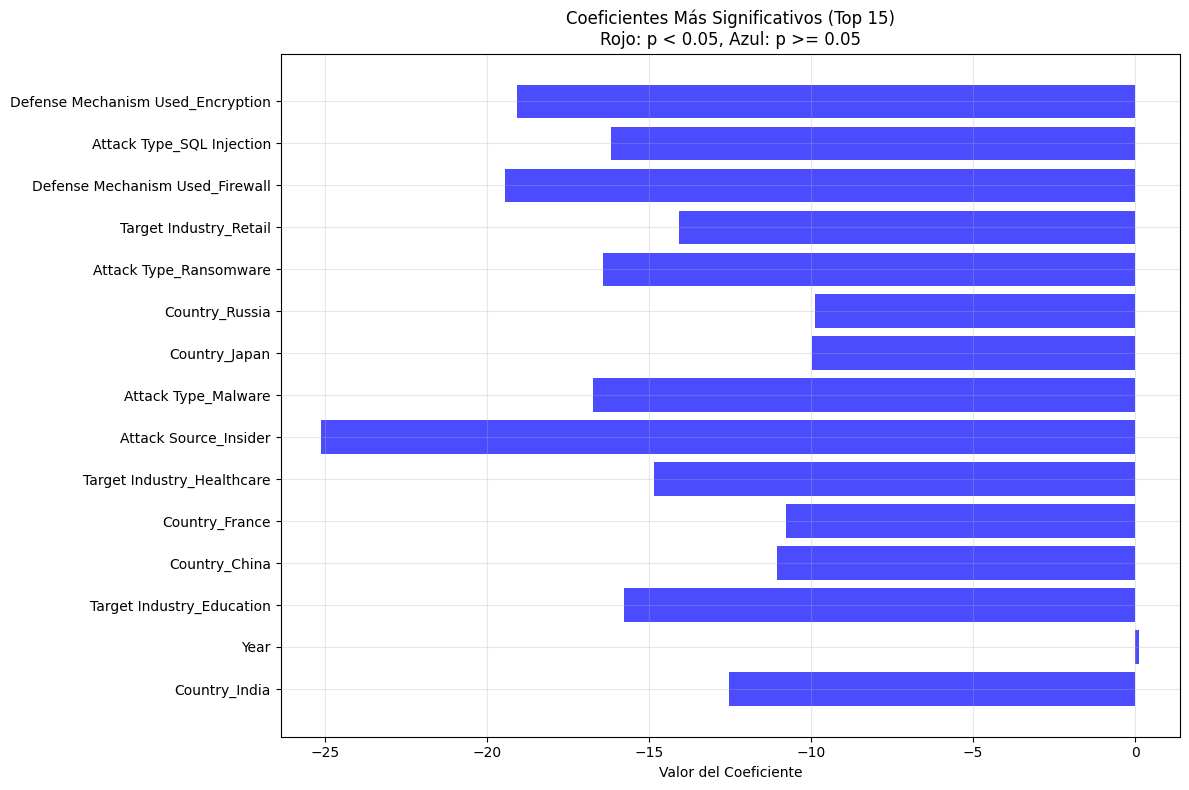

In [5]:
# Análisis de coeficientes más significativos
print("\n=== COEFICIENTES MÁS SIGNIFICATIVOS ===")

# Crear DataFrame con coeficientes y p-valores
coef_data = {
    'Coeficiente': model_ols_multiple.params,
    'P-valor': model_ols_multiple.pvalues,
    'Error_Estándar': model_ols_multiple.bse,
    'T_estadístico': model_ols_multiple.tvalues
}

# Agregar nombres de características
coef_data['Característica'] = ['const'] + feature_names_processed

coef_df = pd.DataFrame(coef_data)
coef_df_sorted = coef_df.sort_values('P-valor')

print("Top 10 coeficientes más significativos:")
print(coef_df_sorted.head(10)[['Característica', 'Coeficiente', 'P-valor', 'T_estadístico']])

# Visualización de coeficientes significativos
plt.figure(figsize=(12, 8))
top_coefs = coef_df_sorted.head(15)  # Top 15 coeficientes más significativos
names = top_coefs['Característica']
values = top_coefs['Coeficiente']
colors = ['red' if p < 0.05 else 'blue' for p in top_coefs['P-valor']]

plt.barh(range(len(names)), values, color=colors, alpha=0.7)
plt.yticks(range(len(names)), names)
plt.xlabel('Valor del Coeficiente')
plt.title('Coeficientes Más Significativos (Top 15)\nRojo: p < 0.05, Azul: p >= 0.05')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


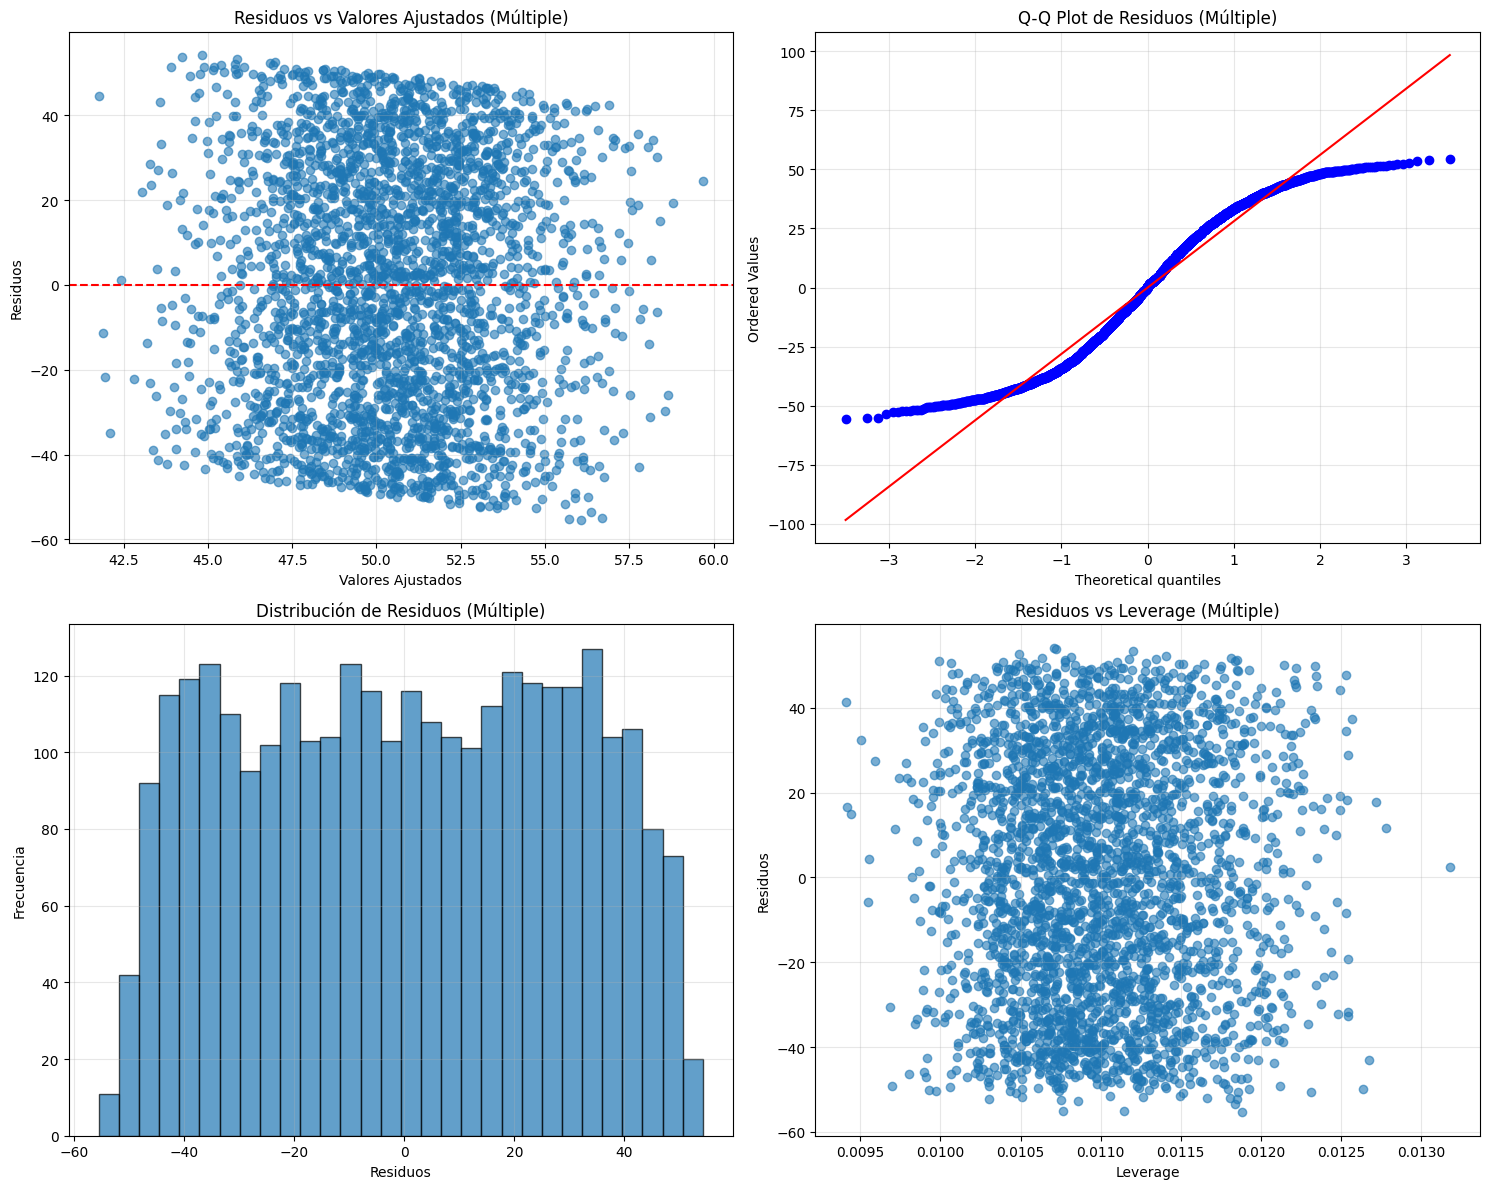

In [6]:
# Gráficos de diagnóstico para OLS múltiple
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Residuals vs Fitted
axes[0,0].scatter(model_ols_multiple.fittedvalues, model_ols_multiple.resid, alpha=0.6)
axes[0,0].axhline(y=0, color='r', linestyle='--')
axes[0,0].set_xlabel('Valores Ajustados')
axes[0,0].set_ylabel('Residuos')
axes[0,0].set_title('Residuos vs Valores Ajustados (Múltiple)')
axes[0,0].grid(True, alpha=0.3)

# 2. Q-Q plot
stats.probplot(model_ols_multiple.resid, dist="norm", plot=axes[0,1])
axes[0,1].set_title('Q-Q Plot de Residuos (Múltiple)')
axes[0,1].grid(True, alpha=0.3)

# 3. Histograma de residuos
axes[1,0].hist(model_ols_multiple.resid, bins=30, alpha=0.7, edgecolor='black')
axes[1,0].set_xlabel('Residuos')
axes[1,0].set_ylabel('Frecuencia')
axes[1,0].set_title('Distribución de Residuos (Múltiple)')
axes[1,0].grid(True, alpha=0.3)

# 4. Residuals vs Leverage
influence_mult = OLSInfluence(model_ols_multiple)
axes[1,1].scatter(influence_mult.hat_matrix_diag, model_ols_multiple.resid, alpha=0.6)
axes[1,1].set_xlabel('Leverage')
axes[1,1].set_ylabel('Residuos')
axes[1,1].set_title('Residuos vs Leverage (Múltiple)')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


=== ANÁLISIS DE OUTLIERS E INFLUENCIA (MÚLTIPLE) ===
Observaciones con alta influencia (leverage): 0
Outliers en residuos (|resid| > 3σ): 0


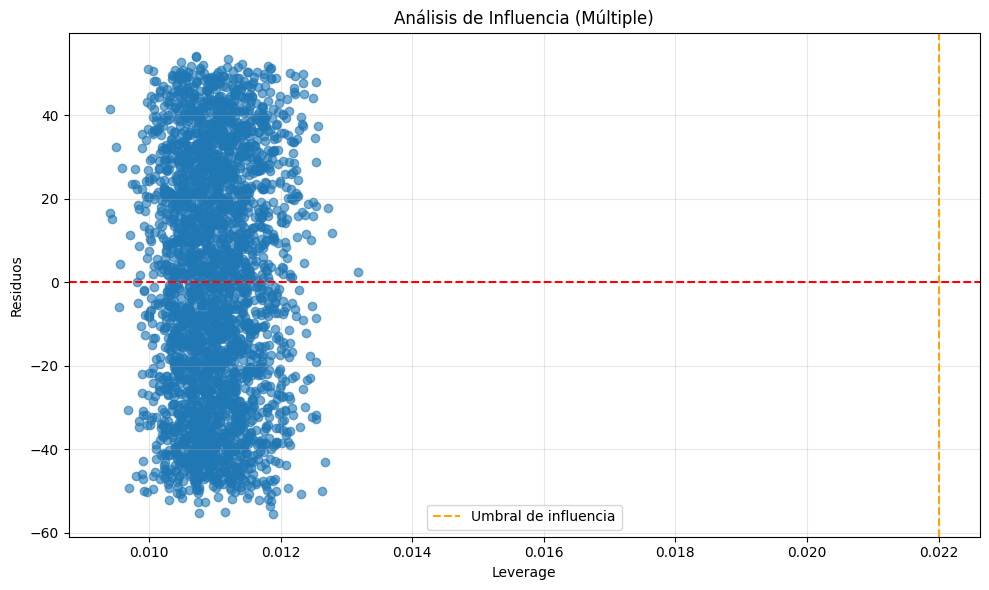


=== RESUMEN FINAL ===
R²: 0.0096
R² ajustado: -0.0010
F-statistic: 0.9020 (p-valor: 0.6257)
AIC: 28710.05
BIC: 28908.26
Número de observaciones: 3000.0
Grados de libertad del modelo: 32.0
Grados de libertad de residuos: 2967.0


In [7]:
# Análisis de outliers e influencia para OLS múltiple
print("=== ANÁLISIS DE OUTLIERS E INFLUENCIA (MÚLTIPLE) ===")

# Identificar observaciones con alta influencia
leverage_mult = influence_mult.hat_matrix_diag
high_leverage_mult = leverage_mult > 2 * leverage_mult.mean()
print(f"Observaciones con alta influencia (leverage): {high_leverage_mult.sum()}")

# Identificar outliers en residuos
resid_std_mult = np.abs(model_ols_multiple.resid) / model_ols_multiple.resid.std()
outliers_mult = resid_std_mult > 3
print(f"Outliers en residuos (|resid| > 3σ): {outliers_mult.sum()}")

# Mostrar observaciones problemáticas
if high_leverage_mult.any() or outliers_mult.any():
    problem_indices_mult = np.where(high_leverage_mult | outliers_mult)[0]
    print(f"\nÍndices de observaciones problemáticas: {problem_indices_mult[:10]}...")  # Mostrar solo los primeros 10
    
    # Crear DataFrame con observaciones problemáticas
    problem_df_mult = df.iloc[problem_indices_mult[:10]][COLS_X_MULTIPLE + [COL_Y]]
    print("\nObservaciones problemáticas:")
    print(problem_df_mult)

# Gráfico de influencia
plt.figure(figsize=(10, 6))
plt.scatter(leverage_mult, model_ols_multiple.resid, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=2*leverage_mult.mean(), color='orange', linestyle='--', label='Umbral de influencia')
plt.xlabel('Leverage')
plt.ylabel('Residuos')
plt.title('Análisis de Influencia (Múltiple)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Resumen final
print(f"\n=== RESUMEN FINAL ===")
print(f"R²: {model_ols_multiple.rsquared:.4f}")
print(f"R² ajustado: {model_ols_multiple.rsquared_adj:.4f}")
print(f"F-statistic: {model_ols_multiple.fvalue:.4f} (p-valor: {model_ols_multiple.f_pvalue:.4f})")
print(f"AIC: {model_ols_multiple.aic:.2f}")
print(f"BIC: {model_ols_multiple.bic:.2f}")
print(f"Número de observaciones: {model_ols_multiple.nobs}")
print(f"Grados de libertad del modelo: {model_ols_multiple.df_model}")
print(f"Grados de libertad de residuos: {model_ols_multiple.df_resid}")
